# I. IMPORT REQUIRED LIBRARIES

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Basic Libraries
import pandas as pd
import numpy as np
import time
import pickle

# Plotation Libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import plotly.express as px

# Preprocessing Libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import mutual_info_classif

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Model Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score,
    precision_score, recall_score, log_loss, precision_recall_curve, auc,
    classification_report
)

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss

# Hyperparameter Tuning
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    KFold, train_test_split, cross_val_score, StratifiedKFold,
    RandomizedSearchCV, GridSearchCV, HalvingRandomSearchCV
)
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Misc
from sklearn.metrics import make_scorer
from joblib import Parallel, delayed

# II. UPLOAD DATA

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1. CHÍNH THỨC/all step/Data/2. Train Clean/train_clean.csv')
train = train_data_org.copy()
train.head(10)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,2,1,1,0,3,1,0.070366,2,0.716263,1
1,1,3,1,3,0,2,0,0.057496,2,0.598616,0
2,1,2,1,1,0,3,1,0.066347,2,0.058824,1
3,1,1,1,3,1,1,0,0.048348,1,0.667820,0
4,0,1,1,2,1,1,0,0.046259,1,0.100346,0
5,0,1,1,3,0,1,1,0.000000,3,0.574394,0
6,1,1,1,3,0,1,1,0.038578,1,0.826990,0
7,0,2,1,1,0,2,1,0.054696,2,0.214533,1
8,0,1,1,3,1,1,0,0.046488,1,0.062284,0
9,0,1,1,3,1,1,0,0.048631,1,0.242215,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


In [ ]:
train.describe()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,0.540761,1.627461,0.997869,2.156979,0.458210,1.609616,0.504877,0.051193,2.241482,0.499472,0.122563
std,0.498336,0.665683,0.046110,0.831136,0.498251,0.567439,0.499977,0.028791,1.098346,0.289520,0.327936
min,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.040509,1.000000,0.249135,0.000000
50%,1.000000,2.000000,1.000000,2.000000,0.000000,2.000000,1.000000,0.054023,2.000000,0.498270,0.000000
75%,1.000000,2.000000,1.000000,3.000000,1.000000,2.000000,1.000000,0.068405,3.000000,0.750865,0.000000
max,1.000000,3.000000,1.000000,3.000000,1.000000,3.000000,1.000000,0.110249,4.000000,1.000000,1.000000


# III. DEALING WITH IMBALANCED "TARGET"

### 4.1.1 Modeling Response Distrribution Percentage

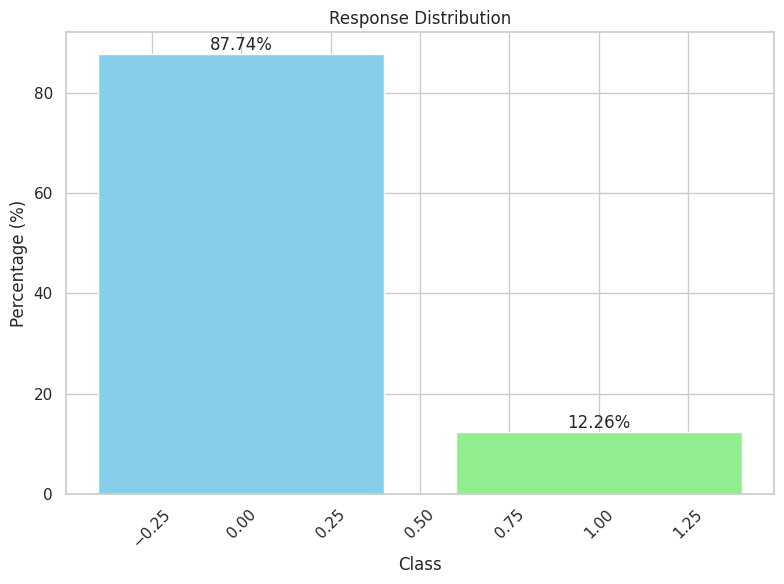

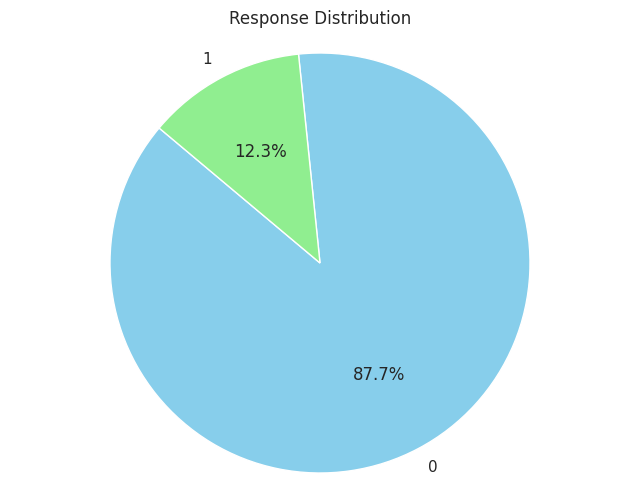

In [ ]:
class_distribution = train['Response'].value_counts(normalize=True) * 100

colors = ['skyblue', 'lightgreen', 'lightcoral']

plt.figure(figsize=(8, 6))
bars = plt.bar(class_distribution.index, class_distribution.values, color=colors)
plt.xlabel('Class')
plt.ylabel('Percentage (%)')
plt.title('Response Distribution')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.pie(class_distribution, labels=class_distribution.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.axis('equal')
plt.title('Response Distribution')
plt.show()

- In conclusion, the data is imbalanced. The results indicate that 87.74% of the customers are not interested (0), while 12.26% of the customers are interested (1).

### 4.1.2 Seperate Target Column ( Response)

In [ ]:
target_column = 'Response'
y = train[target_column]
X = train.drop(target_column, axis=1)

### 4.1.3 Using the method that makes no changes to the data.

- In all the tests below, to determine the optimal method for splitting the training and validation datasets for our 'train.csv' dataset, we utilize the BaggingClassifier to evaluate the accuracy of each method.
- After conducting the tests and obtaining the results, we will convert the code into markdown format if we achieve the highest accuracy percentages.
- We will use ratio all among the test below is 80:20

#### a) Method #1 ( Normal way)

In [ ]:

# Checkpoint
train_copy= train.copy()
target_column = 'Response'
y_copy = y.copy()
X_copy = X.copy()
#READY TO USE :)


In [ ]:

def result_train_and_valid_split_nmw(X, y, n_estimators=50, test_size=0.2, random_state=42):
    base_classifier = BaggingClassifier()
    start_time = time.time()

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Initialize the base classifier as DecisionTreeClassifier
    bagging_classifier = BaggingClassifier(base_classifier, n_estimators=n_estimators, random_state=random_state)
    bagging_classifier.fit(X_train, y_train)

    y_pred = bagging_classifier.predict(X_valid)

    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')

    # Predict the probabilities for each class
    y_pred_proba = bagging_classifier.predict_proba(X_valid)

    # Calculate log loss
    logloss = log_loss(y_valid, y_pred_proba)

    # Tính confusion matrix
    cm = confusion_matrix(y_valid, y_pred)

    end_time = time.time()
    execution_time = end_time - start_time

    # Vẽ confusion matrix bằng seaborn
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print('Accuracy using BaggingClassifier: %.3f' %accuracy)
    print('F1 Score using BaggingClassifier: %.3f' % f1)
    print('Log Loss using BaggingClassifier: %.3f' % logloss)
    print("Thời gian thực thi:", time.strftime("%H:%M:%S", time.gmtime(execution_time)))

    return accuracy, f1, logloss


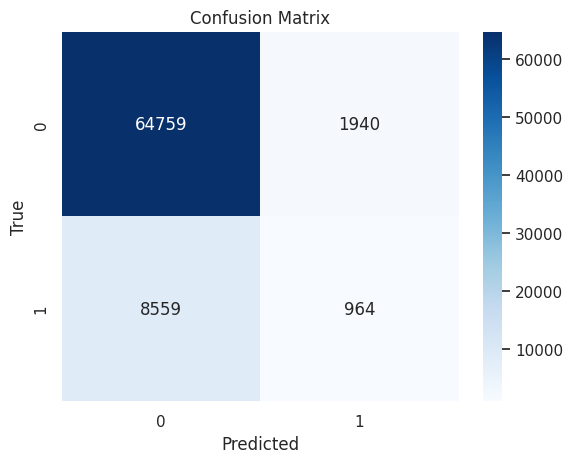

Accuracy using BaggingClassifier: 0.862
F1 Score using BaggingClassifier: 0.540
Log Loss using BaggingClassifier: 0.317
Thời gian thực thi: 00:06:00


In [ ]:

# Gọi hàm và lưu giá trị log loss vào biến
accuracy, f1, logloss = result_train_and_valid_split_nmw(X_copy, y_copy, n_estimators=50, test_size=0.2, random_state=42)


- Accuracy using BaggingClassifier: 0.862
- F1 Score using BaggingClassifier: 0.540
- Log Loss using BaggingClassifier: 0.317
- Thời gian thực thi: 00:06:00

#### b) Method #2 ( Stratified K-Fold way)

In [ ]:

# Checkpoint
train_copy= train.copy()
target_column = 'Response'
y_copy = y.copy()
X_copy = X.copy()
#READY TO USE :)


In [ ]:

def result_train_and_valid_split_Stratified_KFold(X, y, n_estimators=50, n_splits=5, random_state=42):
    accuracy_scores = []
    f1_scores = []
    log_losses = []  # Thêm biến để lưu log loss
    confusion_matrices = []

    # Convert X and y to numpy arrays for indexing
    X = X.values
    y = y.values

    # Initialize the Stratified K-fold cross-validator
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Initialize the base classifier
    base_classifier = BaggingClassifier()

    start_time = time.time()  # Bắt đầu tính thời gian thực thi

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Create and fit the bagging classifier
        bagging_classifier = BaggingClassifier(base_classifier, n_estimators=n_estimators, random_state=random_state)
        bagging_classifier.fit(X_train, y_train)

        # Predict and calculate metrics
        y_pred = bagging_classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        cm = confusion_matrix(y_test, y_pred)

        accuracy_scores.append(accuracy)
        f1_scores.append(f1)
        confusion_matrices.append(cm)

        # Tính và lưu log loss
        y_pred_proba = bagging_classifier.predict_proba(X_test)
        logloss = log_loss(y_test, y_pred_proba)
        log_losses.append(logloss)

    # Calculate mean accuracy and F1 score
    mean_accuracy = np.mean(accuracy_scores)
    mean_f1 = np.mean(f1_scores)

    # Calculate mean confusion matrix
    mean_confusion_matrix = np.mean(confusion_matrices, axis=0)

    # Calculate mean log loss
    mean_log_loss = np.mean(log_losses)

    end_time = time.time()  # Kết thúc tính thời gian thực thi
    execution_time = end_time - start_time

    # Vẽ mean confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(mean_confusion_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Mean Confusion Matrix')
    plt.show()

    print('Mean Accuracy using BaggingClassifier and Stratified K-Fold: %.3f' % mean_accuracy)
    print('Mean F1 Score using BaggingClassifier and Stratified K-Fold: %.3f' % mean_f1)
    print('Mean Log Loss using BaggingClassifier and Stratified K-Fold: %.3f' % mean_log_loss)
    print("Thời gian thực thi:", time.strftime("%H:%M:%S", time.gmtime(execution_time)))



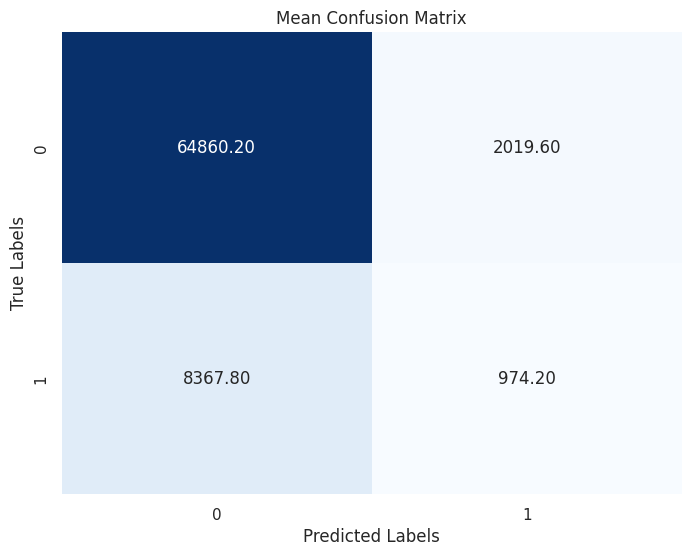

Mean Accuracy using BaggingClassifier and Stratified K-Fold: 0.864
Mean F1 Score using BaggingClassifier and Stratified K-Fold: 0.542
Mean Log Loss using BaggingClassifier and Stratified K-Fold: 0.317
Thời gian thực thi: 00:28:13


In [ ]:

# Sử dụng hàm result_train_and_valid_split_Stratified_KFold để đánh giá mô hình
result_train_and_valid_split_Stratified_KFold(X_copy, y_copy, n_estimators=50, n_splits=5, random_state=42)


- Mean Accuracy using BaggingClassifier and Stratified K-Fold: 0.864
- Mean F1 Score using BaggingClassifier and Stratified K-Fold: 0.542
- Mean Log Loss using BaggingClassifier and Stratified K-Fold: 0.317
- Thời gian thực thi: 00:28:13

#### c) Method #3 (K-fold way)

In [ ]:

# Checkpoint
train_copy= train.copy()
target_column = 'Response'
y_copy = y.copy()
X_copy = X.copy()
#READY TO USE :)


In [ ]:
def result_train_and_valid_split_KFold(X, y, n_estimators=50, n_splits=5, random_state=42):
    accuracy_scores = []
    f1_scores = []
    log_losses = []  # Thêm biến để lưu log loss
    confusion_matrices = []

    # Convert X and y to numpy arrays for indexing
    X = X.values
    y = y.values

    # Initialize the K-fold cross-validator
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    base_classifier = BaggingClassifier()
    start_time = time.time()  # Bắt đầu tính thời gian thực thi

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Create and fit the bagging classifier
        bagging_classifier = BaggingClassifier(base_classifier, n_estimators=n_estimators, random_state=random_state)
        bagging_classifier.fit(X_train, y_train)

        # Predict and calculate metrics
        y_pred = bagging_classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        log_loss_val = log_loss(y_test, bagging_classifier.predict_proba(X_test))  # Tính log loss

        accuracy_scores.append(accuracy)
        f1_scores.append(f1)
        log_losses.append(log_loss_val)
        confusion_matrices.append(confusion_matrix(y_test, y_pred))

    # Calculate mean accuracy, F1 score, and log loss
    mean_accuracy = np.mean(accuracy_scores)
    mean_f1 = np.mean(f1_scores)
    mean_log_loss = np.mean(log_losses)  # Log loss trung bình
    mean_confusion_matrix = np.mean(confusion_matrices, axis=0)

    end_time = time.time()  # Kết thúc tính thời gian thực thi
    execution_time = end_time - start_time

    # Vẽ mean confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(mean_confusion_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Mean Confusion Matrix')
    plt.show()

    print('Mean Accuracy using BaggingClassifier and K-Fold: %.3f' % mean_accuracy)
    print('Mean F1 Score using BaggingClassifier and K-Fold: %.3f' % mean_f1)
    print('Mean Log Loss using BaggingClassifier and K-Fold: %.3f' % mean_log_loss)
    print("Thời gian thực thi:", time.strftime("%H:%M:%S", time.gmtime(execution_time)))




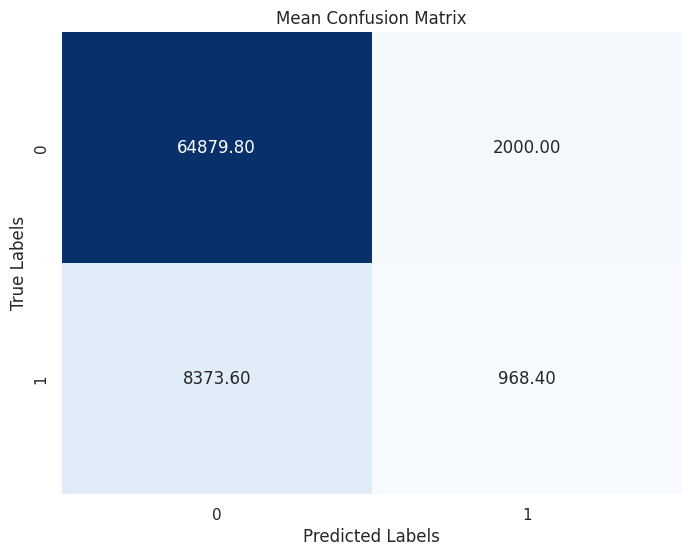

Mean Accuracy using BaggingClassifier and K-Fold: 0.864
Mean F1 Score using BaggingClassifier and K-Fold: 0.542
Mean Log Loss using BaggingClassifier and K-Fold: 0.315
Thời gian thực thi: 00:27:56


In [ ]:

# Sử dụng hàm để đánh giá mô hình
result_train_and_valid_split_KFold(X_copy, y_copy, n_estimators=50, n_splits=5, random_state=42)


- Mean Accuracy using BaggingClassifier and K-Fold: 0.864
- Mean F1 Score using BaggingClassifier and K-Fold: 0.542
- Mean Log Loss using BaggingClassifier and K-Fold: 0.315
- Thời gian thực thi: 00:27:56

### 4.1.4 Using the method that makes changes to the data. (KA)

#### a) Oversampling using SMOTE

In [ ]:

# Checkpoint
train_copy= train.copy()
target_column = 'Response'
y_copy = y.copy()
X_copy = X.copy()
#READY TO USE :)


In [ ]:

def result_train_and_valid_split_SMOTE(X, y, n_estimators=50, test_size=0.2, random_state=42):
    # Sử dụng SMOTE để oversample dữ liệu
    sm = SMOTE()
    X_sm, y_sm = sm.fit_resample(X_copy, y_copy)

    accuracy_scores = []
    f1_scores = []
    log_losses = []  # Thêm biến để lưu log loss
    confusion_matrices = []

    base_classifier = BaggingClassifier()
    start_time = time.time()

    # Train và validate
    X_train, X_valid, y_train, y_valid = train_test_split(X_sm, y_sm, test_size=test_size, stratify=y_sm, random_state=random_state)

    bagging_classifier = BaggingClassifier(base_classifier, n_estimators=n_estimators, random_state=random_state)
    bagging_classifier.fit(X_train, y_train)

    y_pred = bagging_classifier.predict(X_valid)

    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    log_loss_val = log_loss(y_valid, bagging_classifier.predict_proba(X_valid))  # Tính log loss

    # Tính confusion matrix
    cm = confusion_matrix(y_valid, y_pred)

    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    log_losses.append(log_loss_val)
    confusion_matrices.append(cm)

    end_time = time.time()
    execution_time = end_time - start_time

    # Vẽ confusion matrix bằng seaborn
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print('Accuracy using BaggingClassifier: %.3f' % accuracy)
    print('F1 Score using BaggingClassifier: %.3f' % f1)
    print('Log Loss using BaggingClassifier: %.3f' % log_loss_val)
    print("Thời gian thực thi:", time.strftime("%H:%M:%S", time.gmtime(execution_time)))




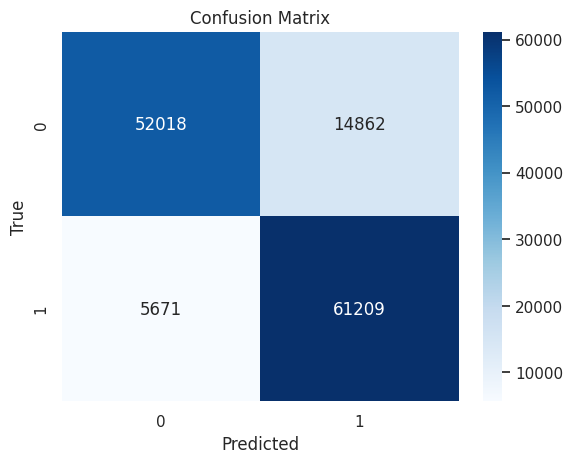

Accuracy using BaggingClassifier: 0.846
F1 Score using BaggingClassifier: 0.846
Log Loss using BaggingClassifier: 0.341
Thời gian thực thi: 00:20:09


In [ ]:

# Sử dụng hàm để đánh giá mô hình
result_train_and_valid_split_SMOTE(X_copy, y_copy, n_estimators=50, test_size=0.2, random_state=42)


- Accuracy using BaggingClassifier: 0.846
- F1 Score using BaggingClassifier: 0.846
- Log Loss using BaggingClassifier: 0.341
- Thời gian thực thi: 00:20:09

#### b) Undersampling using NearMiss

In [ ]:

# Checkpoint
train_copy= train.copy()
target_column = 'Response'
y_copy = y.copy()
X_copy = X.copy()
#READY TO USE :)


In [ ]:
def result_train_and_valid_split_Nearmiss(X, y, n_estimators=50, test_size=0.2, random_state=42):
    # Áp dụng NearMiss để xử lý mất cân bằng dữ liệu
    nm = NearMiss()
    X_res, y_res = nm.fit_resample(X_copy, y_copy)
    X_res.shape, y_res.shape

    accuracy_scores = []
    f1_scores = []
    log_losses = []  # Thêm biến để lưu log loss
    confusion_matrices = []

    # Train và kiểm tra mô hình trên dữ liệu đã xử lý
    base_classifier = BaggingClassifier()
    start_time = time.time()

    X_train, X_valid, y_train, y_valid = train_test_split(X_res, y_res, test_size= test_size, random_state= random_state)

    bagging_classifier = BaggingClassifier(base_classifier, n_estimators= n_estimators, random_state=random_state)

    bagging_classifier.fit(X_train, y_train)

    y_pred = bagging_classifier.predict(X_valid)

    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    log_loss_val = log_loss(y_valid, bagging_classifier.predict_proba(X_valid))  # Tính log loss

    #Tính Confusion Matrix
    cm = confusion_matrix(y_valid, y_pred)

    end_time = time.time()
    execution_time = end_time - start_time

    # Vẽ confusion matrix
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print('Accuracy using BaggingClassifier: %.3f' %accuracy)
    print('F1 Score using BaggingClassifier: %.3f' % f1)
    print('Log Loss using BaggingClassifier: %.3f' % log_loss_val)
    print("Thời gian thực thi:", time.strftime("%H:%M:%S", time.gmtime(execution_time)))




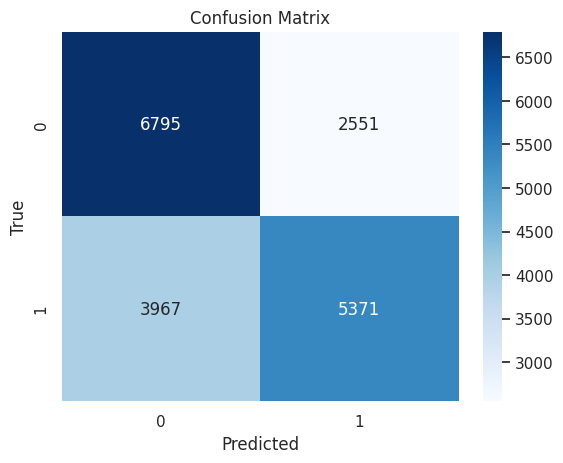

Accuracy using BaggingClassifier: 0.651
F1 Score using BaggingClassifier: 0.649
Log Loss using BaggingClassifier: 0.662
Thời gian thực thi: 00:01:34


In [ ]:

# Gọi hàm để chạy
result_train_and_valid_split_Nearmiss(X_copy, y_copy, n_estimators=50, test_size=0.2, random_state=42)


- Accuracy using BaggingClassifier: 0.651
- F1 Score using BaggingClassifier: 0.649
- Log Loss using BaggingClassifier: 0.662
- Thời gian thực thi: 00:01:34

#### c) Random Oversampling

In [ ]:

# Checkpoint
train_copy= train.copy()
target_column = 'Response'
y_copy = y.copy()
X_copy = X.copy()
#READY TO USE :)


In [ ]:

def result_train_and_valid_split_RandomOverSampler(X, y, n_estimators=50, test_size=0.2, random_state=42):
    # Áp dụng RandomOverSampler để xử lý mất cân bằng dữ liệu
    ros = RandomOverSampler()
    X_ros, y_ros = ros.fit_resample(X_copy, y_copy)
    X_ros.shape, y_ros.shape

    accuracy_scores = []
    f1_scores = []
    log_losses = []  # Thêm biến để lưu log loss
    confusion_matrices = []

    # Train và kiểm tra mô hình trên dữ liệu đã xử lý
    base_classifier = BaggingClassifier()
    start_time = time.time()

    X_train, X_valid, y_train, y_valid = train_test_split(X_ros, y_ros, test_size=test_size, random_state=random_state)

    # Khởi tạo base_classifier

    bagging_classifier = BaggingClassifier(base_classifier, n_estimators= n_estimators, random_state=random_state)
    bagging_classifier.fit(X_train, y_train)

    y_pred = bagging_classifier.predict(X_valid)

    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='macro')
    log_loss_val = log_loss(y_valid, bagging_classifier.predict_proba(X_valid))  # Tính log loss

    # Tính Confusion matrix
    cm = confusion_matrix(y_valid, y_pred)

    end_time = time.time()
    execution_time = end_time - start_time

    # Vẽ confusion matrix
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print('Accuracy using BaggingClassifier: %.3f' % accuracy)
    print('F1 Score using BaggingClassifier: %.3f' % f1)
    print('Log Loss using BaggingClassifier: %.3f' % log_loss_val)
    print("Thời gian thực thi:", time.strftime("%H:%M:%S", time.gmtime(execution_time)))




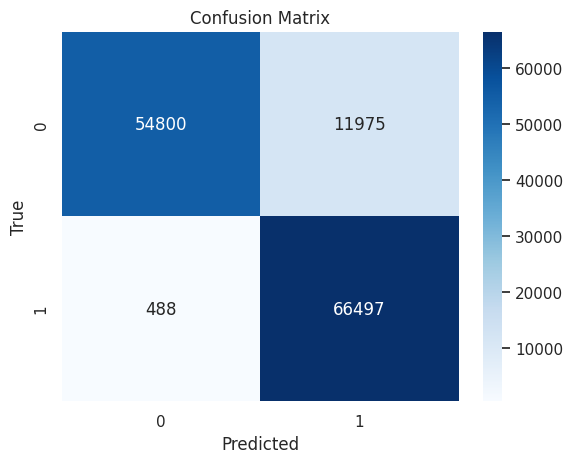

Accuracy using BaggingClassifier: 0.907
F1 Score using BaggingClassifier: 0.906
Log Loss using BaggingClassifier: 0.227
Thời gian thực thi: 00:12:54


In [ ]:

# Gọi hàm để chạy
result_train_and_valid_split_RandomOverSampler(X_copy, y_copy, n_estimators=50, test_size=0.2, random_state=42)


- Accuracy using BaggingClassifier: 0.907
- F1 Score using BaggingClassifier: 0.906
- Log Loss using BaggingClassifier: 0.227
- Thời gian thực thi: 00:12:54

So after comparisions, we found out that Random Oversampling is the best option


### 4.1.5 OUR METHOD

In [ ]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)
X_ros.shape, y_ros.shape

# Train và kiểm tra mô hình trên dữ liệu đã xử lý
X_train, X_valid, y_train, y_valid = train_test_split(X_ros, y_ros, test_size=0.2, random_state=42)

In [ ]:
X_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
609268,1,2,1,2,0,2,1,0.039136,3,0.705882
13455,0,2,1,2,1,2,1,0.053418,4,0.159170
410563,0,2,1,1,0,3,1,0.102256,2,0.667820
496996,1,2,1,1,0,3,1,0.064647,2,0.875433
184109,1,2,1,3,1,2,0,0.050759,3,0.633218


In [ ]:
X_valid.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
436373,1,1,1,3,0,1,1,0.044570,3,0.768166
414084,1,2,1,3,0,2,1,0.055552,2,0.259516
28340,1,2,1,1,1,2,0,0.076977,2,0.141869
495878,1,2,1,3,0,2,1,0.000000,3,0.685121
625770,1,3,1,3,0,2,1,0.040448,3,0.522491


In [ ]:
y_train.head()

609268    1
13455     0
410563    1
496996    1
184109    0
Name: Response, dtype: int64

In [ ]:
y_valid.head()

436373    1
414084    1
28340     0
495878    1
625770    1
Name: Response, dtype: int64